# Fitting Transit Models with Scipy Minimize

Now that we understand how to initialize the model we can use scipy minimize to find the best fitting parameters. This will allow us to find the best fitting transit model based on our data. 

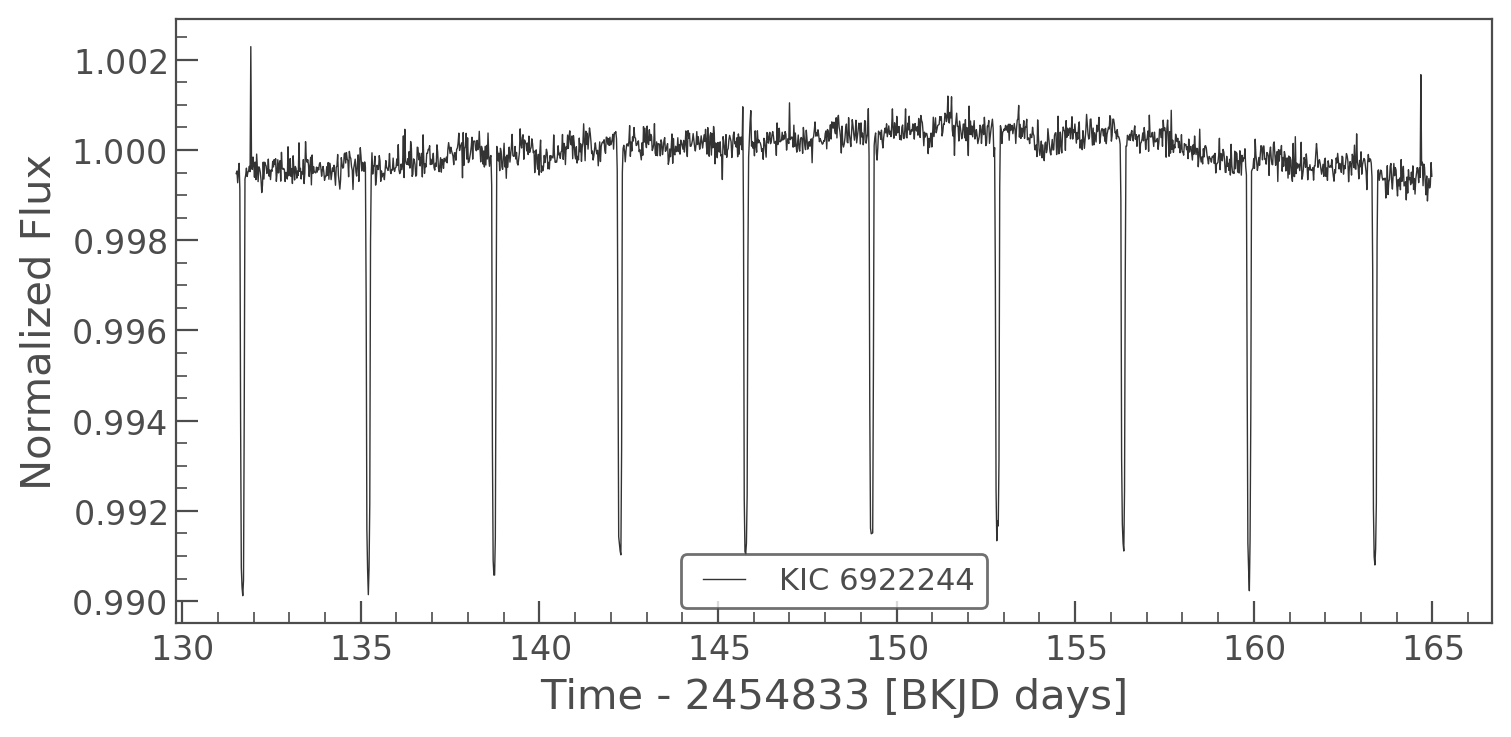

In [64]:
from lightkurve import KeplerLightCurveFile
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

lcf = KeplerLightCurveFile.from_archive('Kepler-8', quality_mask='hard', quarter=1)
lc = lcf.PDCSAP_FLUX.remove_nans()
lc.plot()

In [46]:
import astropy.units as u
from astropy.constants import G
teff = lcf.header()['TEFF']
logg = lcf.header()['LOGG']
feh = lcf.header()['FEH']
r= lcf.header()['RADIUS']*u.solRad

g = 10.**(logg)*(u.cm/u.second**2)
m = ((g*r**2)/G).to(u.solMass)

In [47]:
from PyAstronomy import pyasl
import astropy.units as u
nexa = pyasl.NasaExoplanetArchive()
planet = nexa.selectByPlanetName('kepler-8 b')

# Planet Period
per = planet['pl_orbper']

# Transit midpoint
t0 = planet['pl_tranmid'] - 2454833.0

In [48]:
rp_init = ((np.median(lc.flux) - np.min(lc.flux)) / np.median(lc.flux))**0.5
i_init = 90
d = (((per*u.day).to(u.second))**2 * G * m / (4*np.pi**2))**(1./3.)
a_init = (d.to(u.solRad)/r).value

In [54]:
import batman
params = batman.TransitParams()       #object to store transit parameters
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "quadratic"        #limb darkening model
params.u = [0.5230, 0.1218]           #limb darkening coefficients



def func(guess, return_model=False):
    params.rp=guess[0]
    params.a=guess[1]
    params.inc=guess[2]
    params.t0=guess[3]
    params.per = guess[4]
    
    m = batman.TransitModel(params, np.asarray(lc.time, dtype=float))
    model = m.light_curve(params) * np.nanmedian(lc.flux)
    
    if return_model:
        return(model)
    else:
        return((np.nansum((lc.flux - model)**2/ lc.flux)))

In [55]:
from scipy.optimize import minimize
res = minimize(func, [rp_init, a_init, i_init, t0, per], method='Powell')

In [56]:
# Initial guessses
lcm = func([rp_init, a_init, i_init, t0, per], return_model=True)
# Best Fit
lcm_fit = func(res.x, return_model=True)

Text(0.5,1,'Residuals')

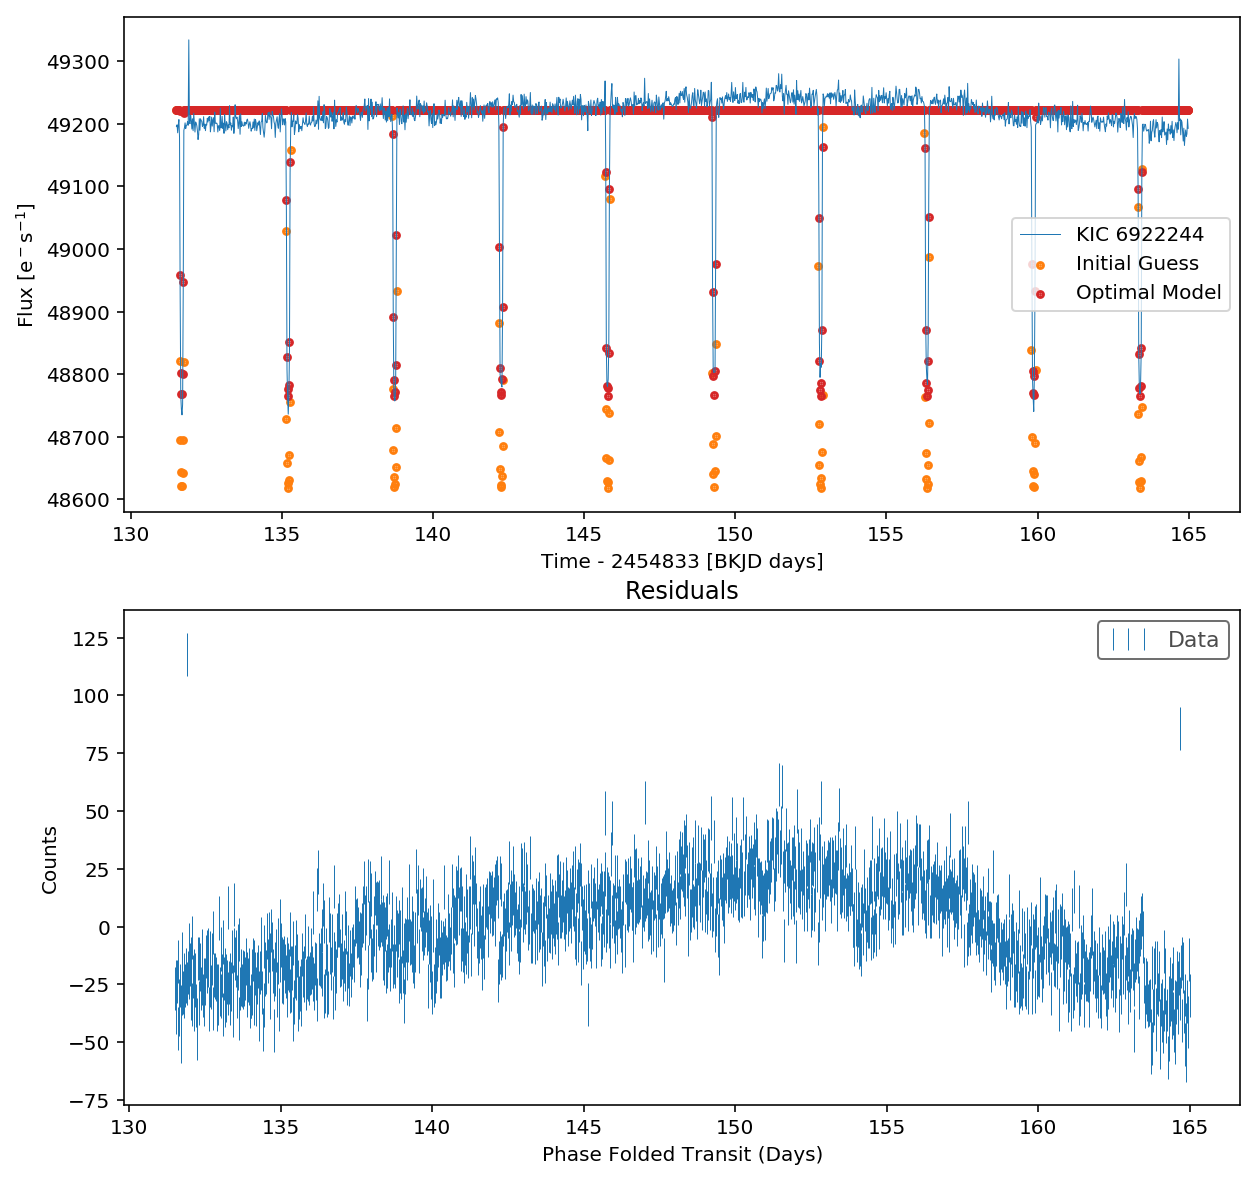

In [66]:
fig, ax = plt.subplots(2,figsize=(10,10))

lc.plot(ax=ax[0], normalize=False)
ax[0].scatter(lc.time, lcm, c='C1',label='Initial Guess', lw=3, s=2, zorder=1)
ax[0].scatter(lc.time, lcm_fit, c='C3',label='Optimal Model', lw=3, s=2, zorder=2)
ax[0].legend()

res = deepcopy(lc)
res -= lcm_fit
res.errorbar(ax=ax[1], label='Data')
ax[1].set_xlabel('Phase Folded Transit (Days)')
ax[1].set_ylabel('Counts')
ax[1].set_title('Residuals')